In [17]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
from pycbc.filter import match, overlap_cplx
from pycbc import psd as psd_func
from pycbc.psd import aLIGOZeroDetHighPower
from simple_pe.waveforms import generate_eccentric_waveform, calculate_eccentric_harmonics
from calcwf import get_h
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [44]:
M = 60
q = 2
e = 0.01

harms = calculate_eccentric_harmonics(M, q, e, 0, 0, 15, 4096, tlen=32, f_ref_e=10, n_ecc_harms=4)

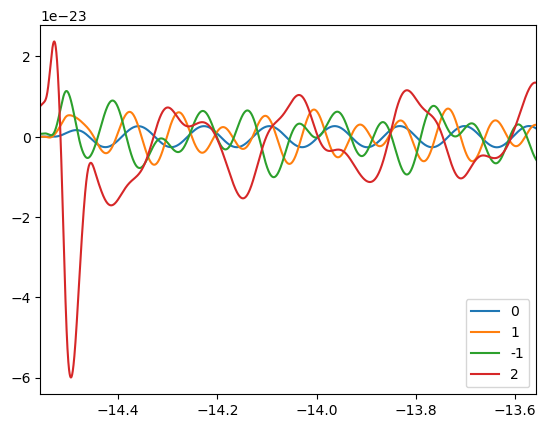

In [45]:
for key in harms.keys():
    wf = harms[key].to_timeseries()
    plt.plot(wf.sample_times, wf, label=str(key))
plt.legend()
plt.xlim(wf.sample_times[0], wf.sample_times[0]+1)
plt.show()

In [40]:
delta_f = 1.0 / harms[0].duration
flen = len(harms[0])
psd = aLIGOZeroDetHighPower(flen, delta_f, 30)

np.abs(overlap_cplx(harms[2], harms[-1], psd=psd, low_frequency_cutoff=30))

0.05543159233386201

Try to write more accurate shifted_e equation:

In [56]:
# Using 3PN ecc evolution from eqs 11, 12 of https://arxiv.org/pdf/2504.12469
def g_of_e(f, M, q):

    eta = q/(1+q)**2
    xi = M*aconst.M_sun.value*np.pi*f

    pf_2 = (-2833/2016+(197/72)*eta)
    pf_3 = (-377/144)*np.pi
    pf_4 = (77006005/24385536-(1143767/145152)*eta+(43807/10368)*eta**2)
    pf_5 = (9901567/1451520-(202589/362880)*eta)*np.pi
    pf_6_1 = (-33320661414619/386266890240+(3317/252)*np.euler_gamma+(180721/41472)*np.pi**2)
    pf_6_2 = ((161339510737/8778792960+(3977/2304)*np.pi**2)*eta-(359037739/20901888)*eta**2)
    pf_6_3 = ((10647791/2239488)*eta**3-(87419/3780)*np.log(2)+(26001/1120)*np.log(3)+(3317/504)*np.log(16*xi**(2/3)))
    pf_6 = pf_6_1+pf_6_2+pf_6_3

    g = 1 + pf_2*xi**(2/3) + pf_3*xi + pf_4*xi**(4/3) + pf_5*xi**(5/3) + pf_6*xi**2

    return g

def shifted_e_3pn(s_f, f, e, M, q):

    s_e = e*(f/s_f)**(19/18)*(g_of_e(s_f, M, q)/g_of_e(f, M, q))
    return s_e

In [57]:
shifted_e_3pn(11, 10, 0.2, 60, 1)

0.21910804364291353

Eccentricity has increased with increased frequency, so this has clearly not worked.

# Testing inputting psds to make_waveform

We have added the ability to input psds to make waveform so we can make harmonics orthogonal to whichever psd/detector we want.

In [2]:
import time
from simple_pe.waveforms import make_waveform

In [27]:
# Defines PSD settings
ifos = ['H1', 'L1', 'V1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'L1': 'aLIGO175MpcT1800545',
        'V1': 'AdVO4T1800545',
        'f_low': 20,
        'f_high': 2048,
        'length': 32
        }
snr = 18
psds['delta_f'] = 1. / psds['length']
approximant = 'TEOBResumS-Dali-Harms'

# Calculates PSD
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])

# Uses simple-pe to calculate approx. of posterior dist. using metric, eigendirections
pars = {'chirp_mass':24, 'symmetric_mass_ratio':2/9, 'ecc10sqrd': 0, 'spin_1z': 0, 'spin_2z': 0, 'f_ref':20, 'distance': 1}

In [26]:
psd_func.analytical.get_lalsim_psd_list()

['AdVBNSOptimizedSensitivityP1200087',
 'AdVDesignSensitivityP1200087',
 'AdVEarlyHighSensitivityP1200087',
 'AdVEarlyLowSensitivityP1200087',
 'AdVLateHighSensitivityP1200087',
 'AdVLateLowSensitivityP1200087',
 'AdVMidHighSensitivityP1200087',
 'AdVMidLowSensitivityP1200087',
 'AdVO3LowT1800545',
 'AdVO4IntermediateT1800545',
 'AdVO4T1800545',
 'AdvVirgo',
 'CosmicExplorerP1600143',
 'CosmicExplorerPessimisticP1600143',
 'CosmicExplorerWidebandP1600143',
 'EinsteinTelescopeP1600143',
 'GEO',
 'GEOHF',
 'KAGRA',
 'KAGRA128MpcT1800545',
 'KAGRA25MpcT1800545',
 'KAGRA80MpcT1800545',
 'KAGRADesignSensitivityT1600593',
 'KAGRAEarlySensitivityT1600593',
 'KAGRALateSensitivityT1600593',
 'KAGRAMidSensitivityT1600593',
 'KAGRAOpeningSensitivityT1600593',
 'TAMA',
 'Virgo',
 'aLIGO140MpcT1800545',
 'aLIGO175MpcT1800545',
 'aLIGOAPlusDesignSensitivityT1800042',
 'aLIGOAdVO3LowT1800545',
 'aLIGOAdVO4IntermediateT1800545',
 'aLIGOAdVO4T1800545',
 'aLIGOBHBH20Deg',
 'aLIGOBHBH20DegGWINC',
 'aLIGO

In [28]:
no_psd_hps = make_waveform(pars, psds['delta_f'], psds['f_low'], psds['length'] * psds['f_high'] + 1, approximant=approximant, n_ecc_harms=4)
single_psd_hps = make_waveform(pars, psds['delta_f'], psds['f_low'], psds['length'] * psds['f_high'] + 1, approximant=approximant, n_ecc_harms=4, ecc_harm_psd=pycbc_psd['H1'])
dict_psd_hps = make_waveform(pars, psds['delta_f'], psds['f_low'], psds['length'] * psds['f_high'] + 1, approximant=approximant, n_ecc_harms=4, ecc_harm_psd=pycbc_psd)

2025-05-08  11:03:36 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-05-08  11:03:36 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2025-05-08  11:03:39 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-05-08  11:03:39 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2025-05-08  11:03:41 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-05-08  11:03:41 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default


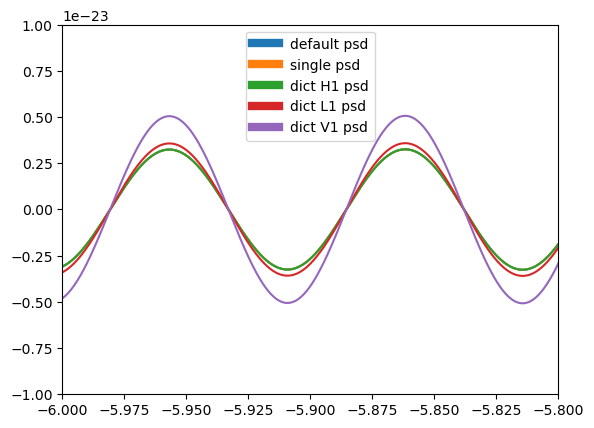

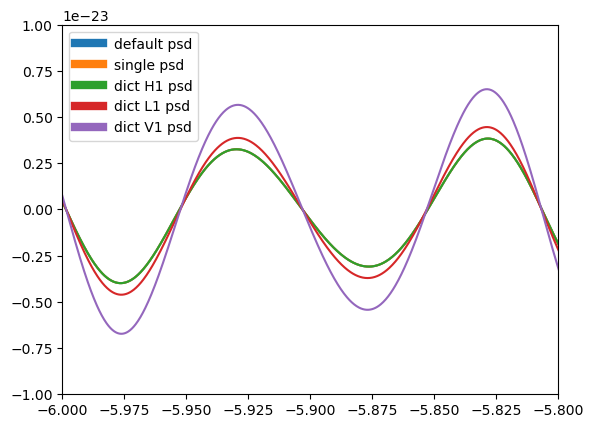

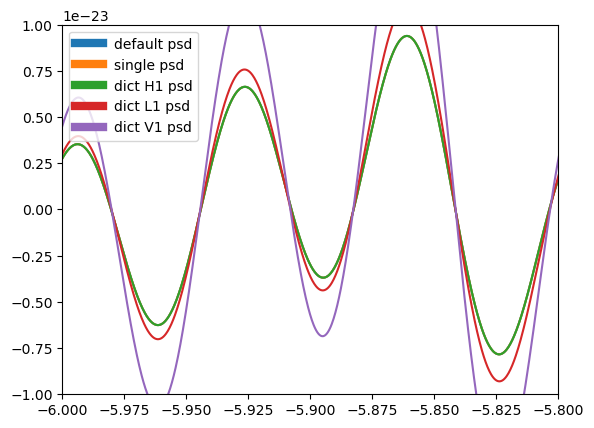

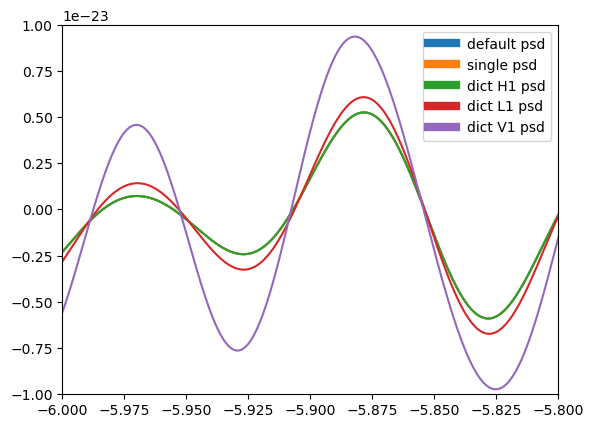

In [32]:
no_psd_ts = {harm: no_psd_hps[harm].to_timeseries() for harm in no_psd_hps.keys()}
single_psd_ts = {harm: single_psd_hps[harm].to_timeseries() for harm in single_psd_hps.keys()}
H1_psd_ts = {harm: dict_psd_hps['H1'][harm].to_timeseries() for harm in dict_psd_hps['H1'].keys()}
L1_psd_ts = {harm: dict_psd_hps['L1'][harm].to_timeseries() for harm in dict_psd_hps['L1'].keys()}
V1_psd_ts = {harm: dict_psd_hps['V1'][harm].to_timeseries() for harm in dict_psd_hps['V1'].keys()}

for harm in no_psd_hps.keys():
    plt.plot(no_psd_ts[harm].sample_times, no_psd_ts[harm], c='C0', label='default psd')
    plt.plot(single_psd_ts[harm].sample_times, single_psd_ts[harm], c='C1', label='single psd')
    plt.plot(H1_psd_ts[harm].sample_times, H1_psd_ts[harm], c='C2', label='dict H1 psd')
    plt.plot(L1_psd_ts[harm].sample_times, L1_psd_ts[harm], c='C3', label='dict L1 psd')
    plt.plot(V1_psd_ts[harm].sample_times, V1_psd_ts[harm], c='C4', label='dict V1 psd')
    plt.xlim(-6,-5.8)
    plt.ylim(-1e-23,1e-23)
    plt.legend()
    plt.show()

In [10]:
start = time.time()
for i in range(20):
    hps = make_waveform(pars, psds['delta_f'], psds['f_low'], psds['length'] * psds['f_high'] + 1, approximant=approximant, n_ecc_harms=4)
end = time.time()
print(end-start)

start = time.time()
for i in range(20):
    hps = make_waveform(pars, psds['delta_f'], psds['f_low'], psds['length'] * psds['f_high'] + 1, approximant=approximant, n_ecc_harms=4, ecc_harm_psd=pycbc_psd)
end = time.time()
print(end-start)

2025-05-08  10:42:37 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-05-08  10:42:37 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2025-05-08  10:42:40 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-05-08  10:42:40 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2025-05-08  10:42:42 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-05-08  10:42:42 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2025-05-08  10:42:44 PESummary WARNING : Could not find f_final in input file and one was not passed from 

57.36924481391907


2025-05-08  10:43:38 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-05-08  10:43:38 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2025-05-08  10:43:43 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-05-08  10:43:43 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2025-05-08  10:43:47 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-05-08  10:43:47 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2025-05-08  10:43:51 PESummary WARNING : Could not find f_final in input file and one was not passed from 

70.46699285507202
